# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)#~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(1, Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [9]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 667.899805082941
eps: 0.25 --> VarE: 10.71105556477284
eps: 0.125 --> VarE: 25.477371601651072
eps: 0.0625 --> VarE: 2.741682282388976
eps: 0.03125 --> VarE: 1.5428650112902709


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.02447108120693197
samples: 243--> ESS: 0.012619559317701218
samples: 447--> ESS: 0.02138440580122325
samples: 739--> ESS: 0.020657365385385887


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.21148237750974663, 0.7310896255867678, 0.0, 8.8102837326117]
 [0.21148237750974663, 0.7310896255867678, 2.5901411914848644, 11.572025819488804]
 [0.21152610118351575, 0.7619472630913778, 7.43416645111949, 13.686432331743294]
 [0.21155597829241596, 0.7930154950791823, 5.624526725770995, 15.131853311947895]
 [0.21159183479606813, 0.8240043979504966, 3.656499405893655, 15.915078247109445]
 [0.21159633149847495, 0.8552503184447823, 1.6765710760150085, 16.025051343465137]
 [0.21160598847848006, 0.8864815151336765, -0.27301142483997864, 15.507673457082166]
 [0.2116926066488921, 0.9161898794736457, -1.8604918918590094, 14.495783259649487]
 [0.21183022170930144, 0.9434384837768207, -1.735154828638814, 14.766844999076229]
 [0.21210952299316285, 0.9374918936871632, 1.1022924274841177, 15.64096118162128]
 [0.21227522799082, 0.9119282429874118, 1.9968101166705718, 16.087316591613707]
 [0.21238841598507868, 0.883151070849664, 0.7546794518141535, 15.967259809264604]
 [

In [10]:
#plt.plot(samples_mchmc.E[8000:end])

In [11]:
#mean(samples_mchmc.E[8000:end])

In [12]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [13]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

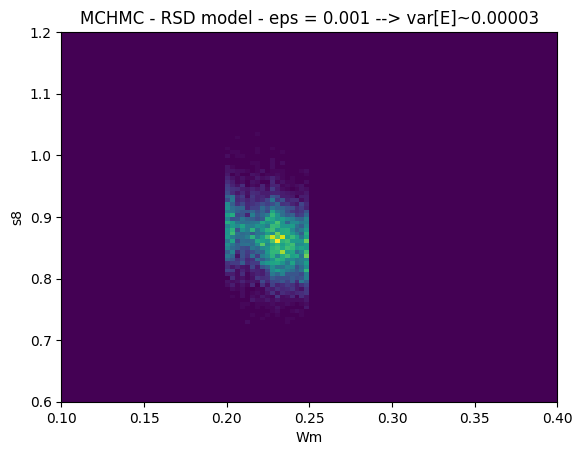

In [14]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [15]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 2833.5682572610444
eps: 0.25 --> VarE: 33.36189207412811
eps: 0.125 --> VarE: 26.194722740329247
eps: 0.0625 --> VarE: 4.3258796541766475
eps: 0.03125 --> VarE: 0.4726454683410933
samples: 100--> ESS: 0.05585388108555683
samples: 243--> ESS: 0.010236274734864716
samples: 447--> ESS: 0.005779376590289338
samples: 739--> ESS: 0.014503171040425943


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.33 seconds
Compute duration  = 2.33 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2248    0.0141     0.0001    0.0013     41.4234    1.0399    ⋯
          σ8    0.8657    0.0401     0.0004    0.0011   2828.2060    1.0019    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2011    0.2130    0.2259    0.2361    0.2481
          σ8    0.7881    0.8388    0.8659    0.8929    0.9449


In [16]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.09 seconds
Compute duration  = 1.09 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2242    0.0146     0.0001    0.0014     43.4083    1.0052    ⋯
          σ8    0.8663    0.0396     0.0004    0.0011   2819.4365    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2000    0.2110    0.2257    0.2373    0.2470
          σ8    0.7891    0.8404    0.8663    0.8923    0.9448


## Parallelization

In [162]:
using Distributed

In [163]:
spl = MCHMC(; nchains=100)

In [164]:
parallel_target  = ParallelTarget(target, 100);

In [178]:
MicroCanonicalHMC.Init_parallel(spl, parallel_target)

(195.49244987877537, Real[-2.649151249825413 0.601558125741589; 1.1880791197958045 0.7437412961837004; … ; 3.076534864152871 0.8376571914951008; 1.1508032026959525 1.2123867466801683], [-0.0006836933314331329 0.10554549898932568; 7.424693270558839e-5 0.044567176810284055; … ; 0.0005055242851635299 0.004506136959704425; 0.0016161966677632402 -0.14251258846299314], Real[11.922277169393189, -11.50597679490941, 1.3579337677832812, -0.19706111896571255, -9.7200283640102, 28.022918922421663, -12.16628488730915, -15.91909379440494, -15.662017340281388, -11.074740250875028  …  36.46049651275178, -1.649185897248207, 21.485601179260414, -16.041206447511662, -11.604260975765332, -12.454227362232029, -7.139431224783162, 40.88505085382221, -14.455879549639226, 30.011188989515492], Real[-1.2378052450084338 -191.08680197621192; 0.1344217334051238 -80.6874700611047; … ; 0.9152357978143534 -8.158219053792266; 2.926073168110387 258.0145532638913])

In [26]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 1996.2515854233613
eps: 0.25 --> VarE: 67.57173174691381
eps: 0.125 --> VarE: 21.004653315651524
eps: 0.0625 --> VarE: 3.501769028929191
eps: 0.03125 --> VarE: 0.5508056954151862
samples: 100--> ESS: 0.024259392448212576
samples: 243--> ESS: 0.012116394754875663
samples: 447--> ESS: 0.007815896751676854
samples: 739--> ESS: 0.019491097336357226


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
chain 1:   3%|█▎                                        |  ETA: 0:00:04
chain 3:   2%|█                                         |  ETA: 0:00:04
chain 2:   2%|█                                         |  ETA: 0:00:04
chain 4:   2%|█                                         |  ETA: 0:00:04
chain 1:   6%|██▌                                       |  ETA: 0:00:03
chain 3:   6%|██▎                                       |  ETA: 0:00:04
chain 4:   6%|██▎                                       |  ETA: 0:00:04
chain 2:   6%|██▎                                       |  ETA: 0:00:04
chain 1:   9%|███▊                                      |  ETA: 0:00:03
chain 3:   8%|███▍                                      |  ETA: 0:00:04
chain 4:   8%|███▋                                      |  ETA: 0:00:04
chain 2:   8%|███▋                                      |  ETA: 0:00:04
chain 1:  12%|█████                               

chain 1:  76%|███████████████████████████████▉          |  ETA: 0:00:01
chain 2:  73%|██████████████████████████████▋           |  ETA: 0:00:01
chain 4:  76%|███████████████████████████████▊          |  ETA: 0:00:01
chain 2:  76%|███████████████████████████████▊          |  ETA: 0:00:01
chain 3:  76%|███████████████████████████████▊          |  ETA: 0:00:01
chain 1:  79%|█████████████████████████████████▏        |  ETA: 0:00:01
chain 4:  78%|█████████████████████████████████         |  ETA: 0:00:01
chain 2:  78%|█████████████████████████████████         |  ETA: 0:00:01
chain 3:  78%|█████████████████████████████████         |  ETA: 0:00:01
chain 1:  82%|██████████████████████████████████▌       |  ETA: 0:00:01
chain 4:  82%|██████████████████████████████████▎       |  ETA: 0:00:01
chain 2:  82%|██████████████████████████████████▎       |  ETA: 0:00:01
chain 3:  82%|██████████████████████████████████▎       |  ETA: 0:00:01
chain 1:  85%|███████████████████████████████████▊      |  ETA: 

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [27]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 1:   4%|█▌                                        |  ETA: 0:00:03
chain 2:   4%|█▌                                        |  ETA: 0:00:03
chain 4:   4%|█▌                                        |  ETA: 0:00:03
chain 3:   4%|█▌                                        |  ETA: 0:00:03
chain 3:   6%|██▌                                       |  ETA: 0:00:03
chain 1:   6%|██▊                                       |  ETA: 0:00:03
chain 2:   6%|██▊                                       |  ETA: 0:00:03
chain 4:   6%|██▊                                       |  ETA: 0:00:03
chain 3:   9%|███▊                                      |  ETA: 0:00:03
chain 1:  10%|████                                      |  ETA: 0:00:03
chain 2:  10%|████                                      |  ETA: 0:00:03
chain 4:  10%|████                                      |  ETA: 0:00:03
chain 3:  12%|█████                                     |  ETA: 0:00:03
chain 2:  12%|█████▎         

chain 2:  78%|████████████████████████████████▊         |  ETA: 0:00:01
chain 4:  79%|█████████████████████████████████▏        |  ETA: 0:00:01
chain 3:  78%|████████████████████████████████▊         |  ETA: 0:00:01
chain 1:  82%|██████████████████████████████████▎       |  ETA: 0:00:01
chain 4:  82%|██████████████████████████████████▌       |  ETA: 0:00:01
chain 3:  81%|██████████████████████████████████        |  ETA: 0:00:01
chain 2:  81%|██████████████████████████████████        |  ETA: 0:00:01
chain 1:  84%|███████████████████████████████████▌      |  ETA: 0:00:01
chain 4:  85%|███████████████████████████████████▊      |  ETA: 0:00:01
chain 3:  84%|███████████████████████████████████▎      |  ETA: 0:00:01
chain 2:  84%|███████████████████████████████████▎      |  ETA: 0:00:01
chain 1:  88%|████████████████████████████████████▊     |  ETA: 0:00:00
chain 3:  87%|████████████████████████████████████▌     |  ETA: 0:00:00
chain 4:  88%|█████████████████████████████████████     |  ETA: 

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [28]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:16┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 6.97 seconds
Compute duration  = 6.97 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2243    0.0144     0.0001    0.0002   7236.7865    0.9999    ⋯
          σ8    0.8665    0.0395     0.0004    0.0004   8282.6227    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [29]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.22751   0.88549   16.1981   3.0  1.0  …  2.0  0.0  1.14554  1.14554
 0.224822  0.798493  14.8161   3.0  1.0     2.0  0.0  1.14554  1.14554
 0.20258   0.987486  11.1097   3.0  1.0     2.0  0.0  1.14554  1.14554
 0.20258   0.987486  11.1097   1.0  1.0     1.0  0.0  1.14554  1.14554
 0.200729  0.999194   9.15528  1.0  1.0     1.0  0.0  1.14554  1.14554
 0.200641  0.883885  13.3884   3.0  1.0  …  2.0  0.0  1.14554  1.14554
 0.200905  0.869517  13.6461   1.0  1.0     1.0  0.0  1.14554  1.14554
 0.200262  0.882866  12.498    1.0  1.0     1.0  0.0  1.14554  1.14554
 0.208243  0.916471  15.3144   3.0  1.0     2.0  0.0  1.14554  1.14554


In [30]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

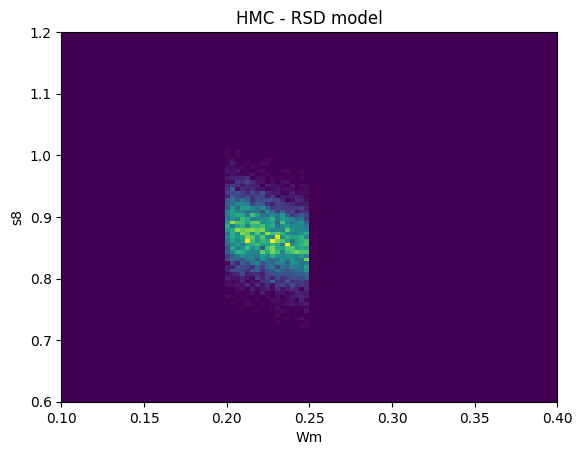

In [31]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");